<a href="https://colab.research.google.com/github/slimf1/ZZ3-DL/blob/main/05_RNN_sequence_classification_Keras_etud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification de séquences par réseaux récurrents
Objectif : classification de données binaires (avis positifs/négatifs sur des films)

## Imports

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, LSTM, Dense


## Chargement des données
Base de données IMDB (avis positif/négatif sur les films). On ne s'intéresse qu'aux 10000 mots les plus courants. On charge également la correspondance mot-> identifiant (id)

In [ ]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)
word_index = imdb.get_word_index()

On créé une correspondance inverse id->mot en ajoutant des mots spéciaux

In [ ]:
index = {word_id + 3: word for word, word_id in word_index.items()}
index[0] = "<pad>" # padding
index[1] = "<sos>" # début de séquence
index[2] = "<oov>" # hors vocabulaire
index[3] = "<unk>" # inconnu

Fonction de lecture des avis

In [ ]:
def decode_review(word_ids):
    return " ".join([index.get(word_id, "<err>") for word_id in word_ids])

print("Un exemple d'avis : ",decode_review(X_train[10]))
print("Avis positif (1)/négatif (0) : ",y_train[1])

Un exemple d'avis :  <sos> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <oov> romance <oov> on to the scene <oov> <oov> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <oov> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <oov> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <oov> sent to prison for fraud he is put in a cell with three others the quietly insane <oov> body building <oov> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <oov> after <oov> part of it they soon realise its magical powers and realise they may

## Modèle de référence
Pour évaluer le modèle RNN, on construit un modèle de référence sur lequel comparer les résultats. Le code vous est fourni

In [ ]:
X_train_text = [decode_review(words_ids) for words_ids in X_train]
X_test_text = [decode_review(words_ids) for words_ids in X_test]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

In [ ]:
processing = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', SGDClassifier(max_iter=50)),])

In [ ]:
processing.fit(X_train_text, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                     

In [ ]:
print("Précision du modèle de référence : ",processing.score(X_test_text, y_test))
print("Test du modèle (avis 0 attendu ) : ", processing.predict(["this movie was really awful"]))
print("Test du modèle (avis 1 attendu ) : ", processing.predict(["this movie was really fantastic"]))

Précision du modèle de référence :  0.88512
Test du modèle (avis 0 attendu ) :  [0]
Test du modèle (avis 1 attendu ) :  [1]


## Classification de séquences par réseau récurrent

In [ ]:
maxlen = 500

# Sequence padding
# Créer un tableau 2D avec 25k avis en lignes et les maxlen premiers mots de l'avis
# en colonne. Si trop court, il sera complété par des 0

X_train_trim = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen)
X_test_trim = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen)

In [ ]:
model = keras.models.Sequential()
model.add(Embedding(10000, output_dim=10))
model.add(LSTM(32))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                5504      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 105,537
Trainable params: 105,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_trim, y_train,epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 16s 88ms/step - loss: 0.1353 - accuracy: 0.9531 - val_loss: 0.3130 - val_accuracy: 0.8858
Epoch 2/10
157/157 [==============================] - 13s 85ms/step - loss: 0.1025 - accuracy: 0.9680 - val_loss: 0.3406 - val_accuracy: 0.8676
Epoch 3/10
157/157 [==============================] - 13s 85ms/step - loss: 0.0909 - accuracy: 0.9704 - val_loss: 0.4540 - val_accuracy: 0.8658
Epoch 4/10
157/157 [==============================] - 13s 84ms/step - loss: 0.0785 - accuracy: 0.9761 - val_loss: 0.4196 - val_accuracy: 0.8674
Epoch 5/10
157/157 [==============================] - 13s 83ms/step - loss: 0.0720 - accuracy: 0.9774 - val_loss: 0.4315 - val_accuracy: 0.8726
Epoch 6/10
157/157 [==============================] - 13s 83ms/step - loss: 0.0859 - accuracy: 0.9726 - val_loss: 0.4867 - val_accuracy: 0.8722
Epoch 7/10
157/157 [==============================] - 13s 84ms/step - loss: 0.0480 - accuracy: 0.9870 - val_loss: 0.4903 - val_accuracy:

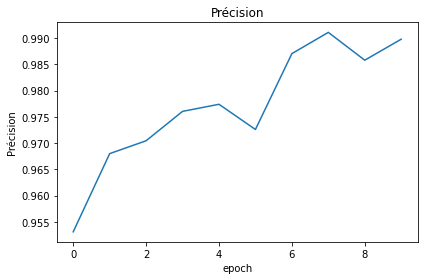

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Précision')
plt.ylabel('Précision')
plt.xlabel('epoch')
plt.tight_layout()

In [ ]:
model.evaluate(X_test_trim, y_test)
print("Test du modèle (avis 0 attendu ) : ", processing.predict(["shit movie..."]))
print("Test du modèle (avis 1 attendu ) : ", processing.predict(["epic film !"]))

782/782 [==============================] - 23s 30ms/step - loss: 0.7705 - accuracy: 0.8161
Test du modèle (avis 0 attendu ) :  [0]
Test du modèle (avis 1 attendu ) :  [1]


## Utilisation d'un réseau bidirectionnel

In [ ]:
from tensorflow.keras.layers import Dropout, Bidirectional

model = keras.models.Sequential()
model.add(Embedding(10000, output_dim=10))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                11008     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_trim, y_train,epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 33s 188ms/step - loss: 0.5950 - accuracy: 0.6887 - val_loss: 0.4256 - val_accuracy: 0.8192
Epoch 2/10
157/157 [==============================] - 29s 182ms/step - loss: 0.3619 - accuracy: 0.8550 - val_loss: 0.3246 - val_accuracy: 0.8630
Epoch 3/10
157/157 [==============================] - 29s 182ms/step - loss: 0.2818 - accuracy: 0.8909 - val_loss: 0.3011 - val_accuracy: 0.8782
Epoch 4/10
157/157 [==============================] - 29s 183ms/step - loss: 0.2355 - accuracy: 0.9102 - val_loss: 0.3526 - val_accuracy: 0.8744
Epoch 5/10
157/157 [==============================] - 29s 182ms/step - loss: 0.2062 - accuracy: 0.9258 - val_loss: 0.3802 - val_accuracy: 0.8692
Epoch 6/10
157/157 [==============================] - 29s 182ms/step - loss: 0.1791 - accuracy: 0.9348 - val_loss: 0.3259 - val_accuracy: 0.8560
Epoch 7/10
157/157 [==============================] - 29s 183ms/step - loss: 0.1618 - accuracy: 0.9443 - val_loss: 0.2904 - val_ac

In [ ]:
model.evaluate(X_test_trim, y_test)
print("Test du modèle (avis 0 attendu ) : ", processing.predict(["this movie was terrible !"]))
print("Test du modèle (avis 1 attendu ) : ", processing.predict(["this movie was good"]))

782/782 [==============================] - 51s 65ms/step - loss: 0.3728 - accuracy: 0.8695
Test du modèle (avis 0 attendu ) :  [0]
Test du modèle (avis 1 attendu ) :  [1]


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fca5793c710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 
